# Functional Principal Component Analysis (FPCA) Tutorial

In this tutorial, we explore how to perform Functional Principal Component Analysis (FPCA) using the `scikit-fda` package in Python. FPCA is a powerful technique for analyzing functional data - data that can be viewed as curves or functions over a continuous domain. This is particularly useful for time series data like growth curves, gene expression profiles, or any measurements collected over time.

## Setup and Installation

First, install the required packages:



## Loading the Berkeley Growth Study Data

The `scikit-fda` package includes the Berkeley growth dataset, making it easy to access.


In [1]:
%pip install scikit-fda pandas numpy matplotlib seaborn scipy
%pip install scikit-fda



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skfda.datasets import fetch_growth
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.grid import FDataGrid


plt.style.use('seaborn-v0_8-whitegrid')

Let's start by exploring the growth data from the Berkeley study


In [3]:
growth_data = fetch_growth()
fd_growth = growth_data['data']

ages = fd_growth.grid_points[0]
n_samples = fd_growth.n_samples

height_data = fd_growth.data_matrix[:, :, 0]  
target = growth_data['target']  

growth_df = []
for i in range(n_samples):
    for j, age in enumerate(ages):
        growth_df.append({
            'age': age,
            'height': height_data[i, j],
            'id': i,
            'child_id': f'Child_{i:03d}',
            'sex': 'Female' if target[i] == 1 else 'Male'
        })

growth_df = pd.DataFrame(growth_df)

print(f"Dataset contains: {growth_df['child_id'].nunique()} children")
print(f"Girls: {(growth_df.groupby('child_id')['sex'].first() == 'Female').sum()}")
print(f"Boys: {(growth_df.groupby('child_id')['sex'].first() == 'Male').sum()}")
print(f"Age range: {ages.min():.1f} to {ages.max():.1f} years")


Dataset contains: 93 children
Girls: 54
Boys: 39
Age range: 1.0 to 18.0 years


The dataset contains height measurements for 93 children (54 girls and 39 boys) measured at 31 time points from age 1 to 18 years.


## Visualizing the Raw Data

Before performing FPCA, let's visualize the growth curves to understand our data.

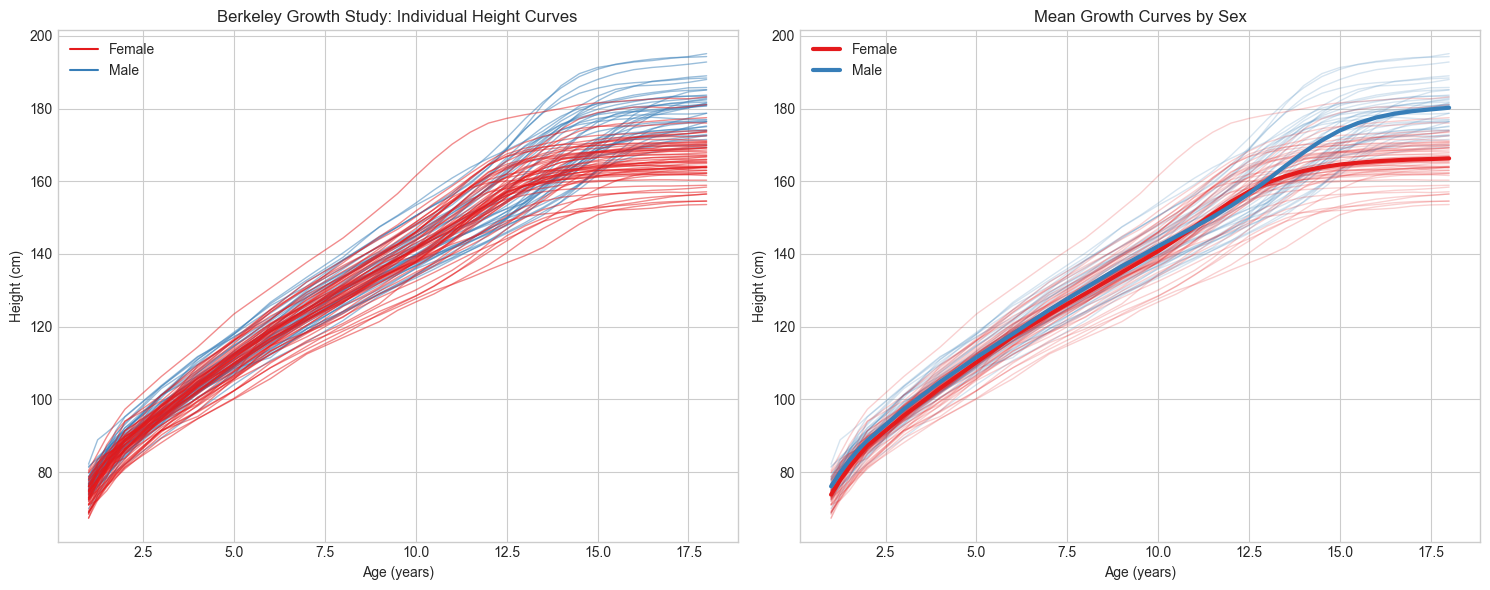

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

for child_id in growth_df['child_id'].unique():
    child_data = growth_df[growth_df['child_id'] == child_id]
    color = '#E41A1C' if child_data.iloc[0]['sex'] == 'Female' else '#377EB8'
    ax1.plot(child_data['age'], child_data['height'], 
             alpha=0.5, color=color, linewidth=1)


from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='#E41A1C', label='Female'),
                   Line2D([0], [0], color='#377EB8', label='Male')]
ax1.legend(handles=legend_elements, loc='upper left')
ax1.set_xlabel('Age (years)')
ax1.set_ylabel('Height (cm)')
ax1.set_title('Berkeley Growth Study: Individual Height Curves')

mean_curves = growth_df.groupby(['age', 'sex'])['height'].agg(['mean', 'std']).reset_index()

for child_id in growth_df['child_id'].unique():
    child_data = growth_df[growth_df['child_id'] == child_id]
    color = '#E41A1C' if child_data.iloc[0]['sex'] == 'Female' else '#377EB8'
    ax2.plot(child_data['age'], child_data['height'], 
             alpha=0.2, color=color, linewidth=1)

for sex, color in [('Female', '#E41A1C'), ('Male', '#377EB8')]:
    sex_data = mean_curves[mean_curves['sex'] == sex]
    ax2.plot(sex_data['age'], sex_data['mean'], 
             color=color, linewidth=3, label=sex)

ax2.legend(loc='upper left')
ax2.set_xlabel('Age (years)')
ax2.set_ylabel('Height (cm)')
ax2.set_title('Mean Growth Curves by Sex')

plt.tight_layout()
plt.show()

## Performing FPCA

Now we'll perform FPCA on the growth curves. The first step is to convert our data into the format required by the `scikit-fda` package.


In [5]:
print(f"FPCA input created with {fd_growth.n_samples} curves")
print(f"Each curve has {len(ages)} time points")

FPCA input created with 93 curves
Each curve has 31 time points


## FPCA Implementation in Python

### Data Requirements
The data should be structured as:
- **Dense functional data**: All subjects measured at the same time points
- **Format**: Matrix where rows are subjects and columns are time points
- **Example**: For growth data, each child (row) has height measurements at all ages (columns)

### Implementation Details
In scikit-fda:
- **Data Type**: Automatically handles dense data (all subjects measured at same time points)
- **Component Selection**: We manually implement FVE (Fraction of Variance Explained) by:
 - Initially fitting with excess components (n_components=10)
 - Calculating cumulative variance explained
 - Selecting components that explain 95% of variation
- **Centering**: Set to True to compute mean function


In [6]:
fpca = FPCA(n_components=10, centering=True)
fpca.fit(fd_growth)

scores = fpca.transform(fd_growth)

explained_variance = fpca.explained_variance_
explained_variance_ratio = fpca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

var_explained = np.round(explained_variance_ratio * 100, 1)

print(f"Components selected: {n_components_95}")
print(f"Total variance explained: {cumulative_variance[n_components_95-1]*100:.1f}%\n")

variance_summary = pd.DataFrame({
    'PC': range(1, n_components_95 + 1),
    'Variance_Explained': var_explained[:n_components_95],
    'Cumulative': np.round(cumulative_variance[:n_components_95] * 100, 1)
})

print(variance_summary)

Components selected: 3
Total variance explained: 97.5%

   PC  Variance_Explained  Cumulative
0   1                81.0        81.0
1   2                13.5        94.5
2   3                 3.0        97.5



## Understanding the Principal Components

FPCA decomposes each curve into a mean function plus weighted combinations of eigenfunctions (principal component functions). Let's visualize these components.


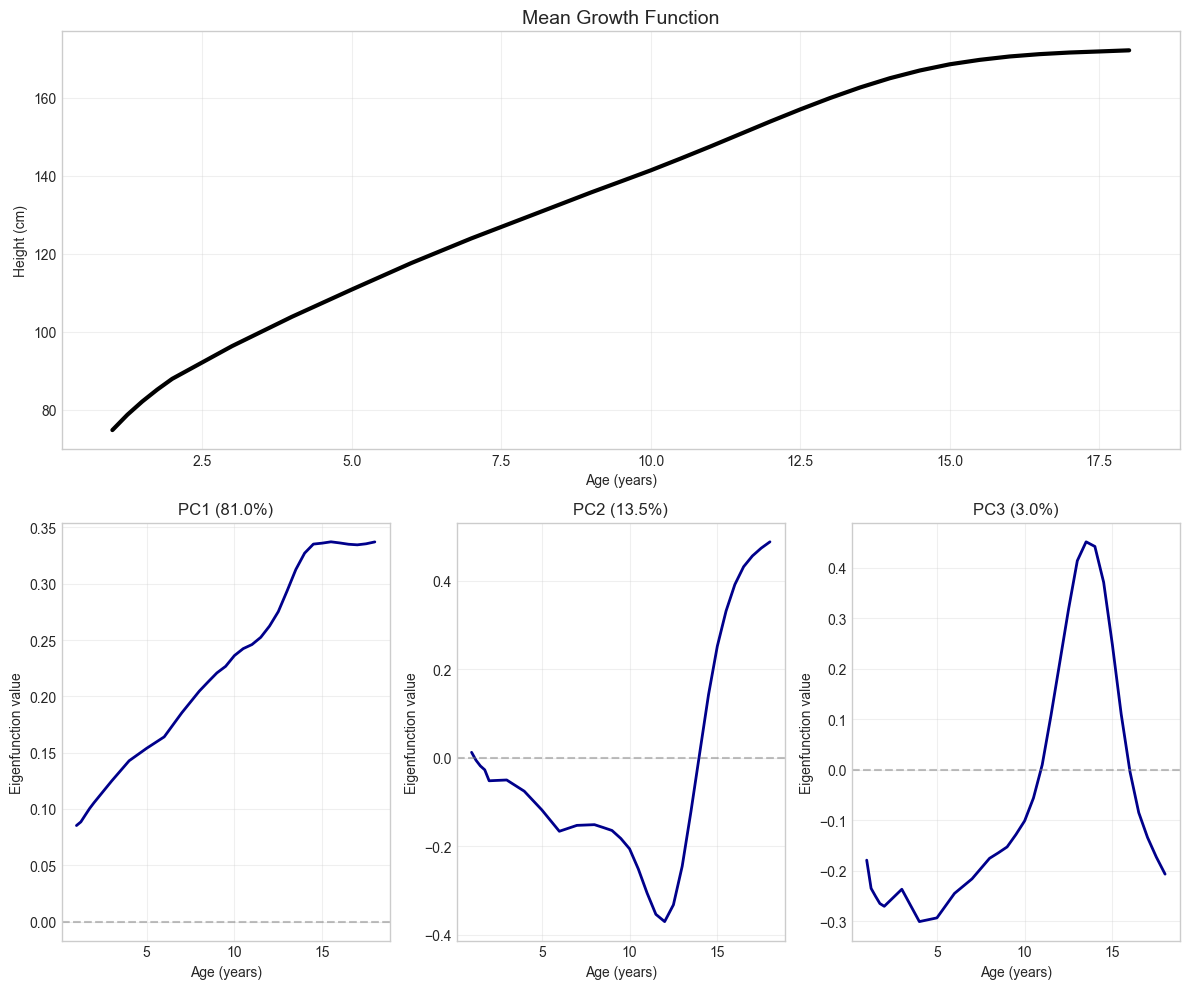

In [7]:
mean_function = fpca.mean_
components = fpca.components_

fig = plt.figure(figsize=(12, 10))

ax1 = plt.subplot(2, 1, 1)
ax1.plot(ages, mean_function.data_matrix[0, :, 0], linewidth=3, color='black')
ax1.set_xlabel('Age (years)')
ax1.set_ylabel('Height (cm)')
ax1.set_title('Mean Growth Function', fontsize=14)
ax1.grid(True, alpha=0.3)

for i in range(3):
    ax = plt.subplot(2, 3, i + 4)
    ax.plot(ages, components.data_matrix[i, :, 0], linewidth=2, color='darkblue')
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Age (years)')
    ax.set_ylabel('Eigenfunction value')
    ax.set_title(f'PC{i+1} ({var_explained[i]:.1f}%)', fontsize=12)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Interpreting PC Effects

To understand what each PC represents, we can visualize how positive and negative scores affect the growth curves.


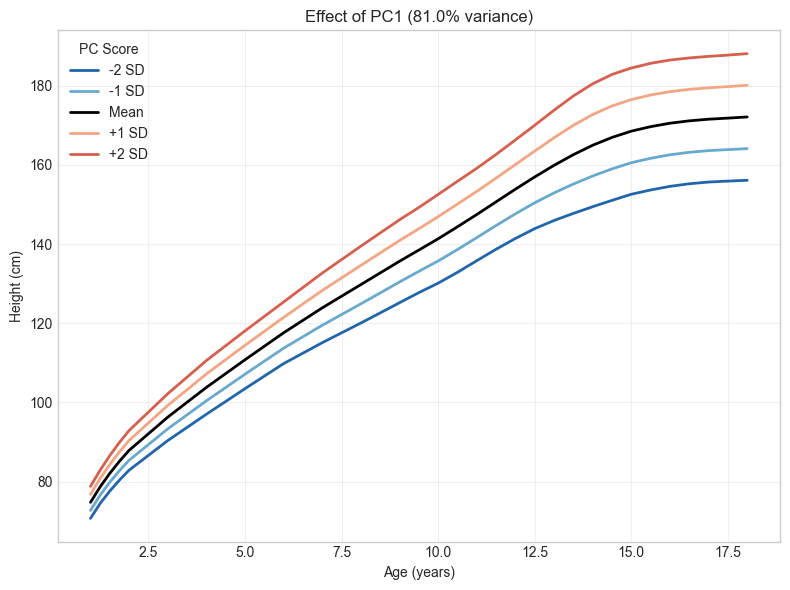

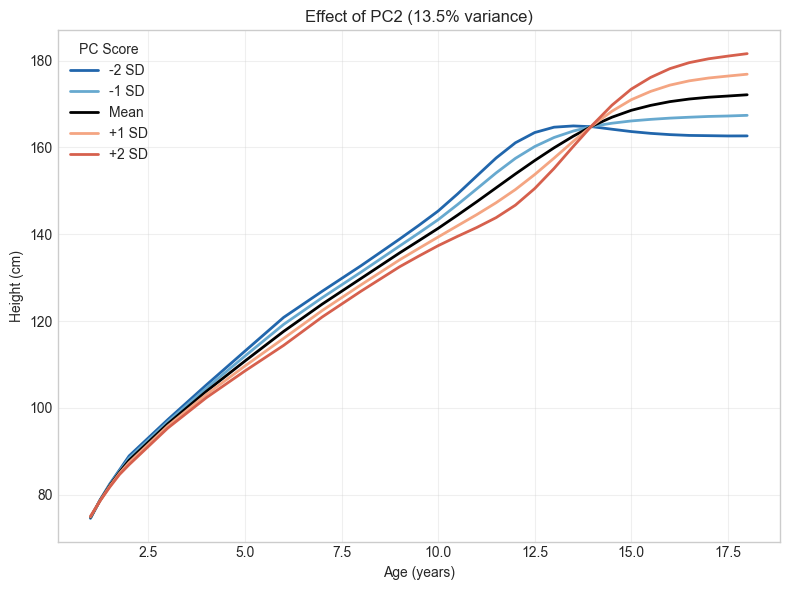

In [8]:
def show_pc_effect(fpca, pc_num, var_explained):
    scores_sd = np.array([-2, -1, 0, 1, 2])
    colors = ['#2166AC', '#67A9CF', 'black', '#F4A582', '#D6604D']
    labels = ['-2 SD', '-1 SD', 'Mean', '+1 SD', '+2 SD']
    
    plt.figure(figsize=(8, 6))
    
    mean_curve = fpca.mean_.data_matrix[0, :, 0]
    
    pc_curve = fpca.components_.data_matrix[pc_num, :, 0]
    pc_std = np.sqrt(fpca.explained_variance_[pc_num])
    
    for score, color, label in zip(scores_sd, colors, labels):
        perturbed_curve = mean_curve + score * pc_std * pc_curve
        plt.plot(ages, perturbed_curve, linewidth=2, color=color, label=label)
    
    plt.xlabel('Age (years)')
    plt.ylabel('Height (cm)')
    plt.title(f'Effect of PC{pc_num + 1} ({var_explained[pc_num]:.1f}% variance)')
    plt.legend(title='PC Score')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

p_pc1_effect = show_pc_effect(fpca, 0, var_explained)
p_pc2_effect = show_pc_effect(fpca, 1, var_explained)


**Interpretation:**
- **PC1** captures overall height differences (tall vs short children)
- **PC2** captures growth timing (early vs late growth spurts)

## Analyzing PC Scores

The PC scores tell us how much of each component is present in each child's growth curve.


In [9]:
pc_scores_df = pd.DataFrame(
    scores[:, :n_components_95],
    columns=[f'PC{i+1}' for i in range(n_components_95)]
)
pc_scores_df['child_id'] = [f'Child_{i:03d}' for i in range(n_samples)]
pc_scores_df['sex'] = ['Female' if t == 1 else 'Male' for t in target]


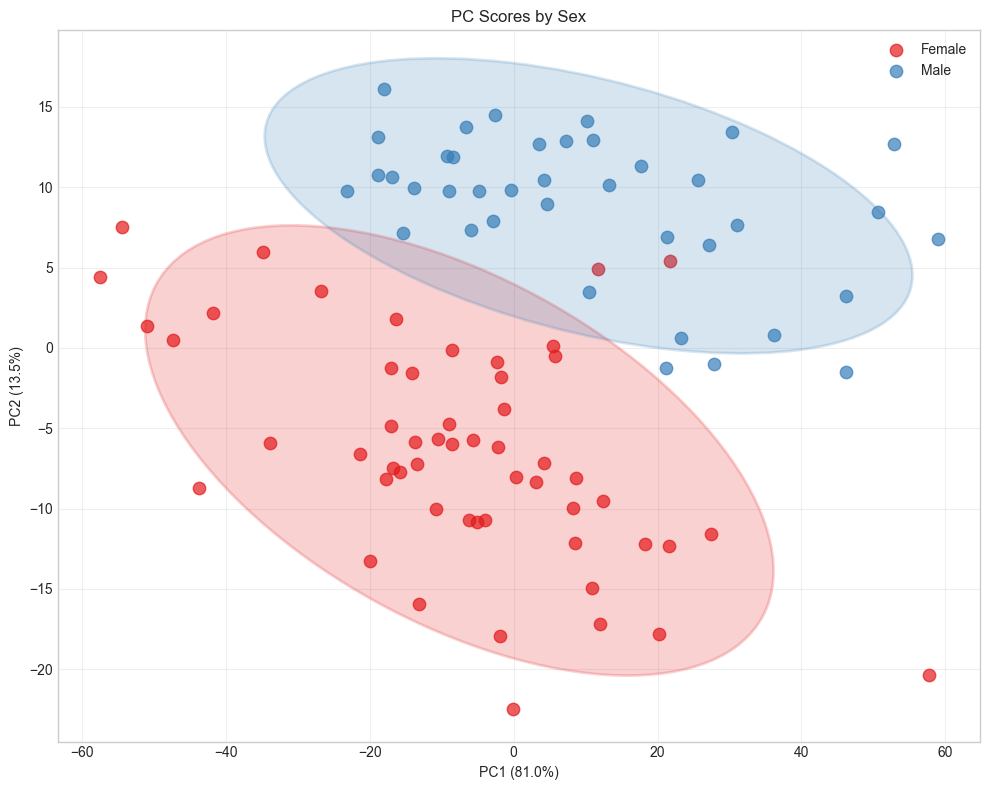

In [10]:

plt.figure(figsize=(10, 8))

for sex, color in [('Female', '#E41A1C'), ('Male', '#377EB8')]:
    mask = pc_scores_df['sex'] == sex
    plt.scatter(pc_scores_df.loc[mask, 'PC1'], 
                pc_scores_df.loc[mask, 'PC2'],
                color=color, alpha=0.7, s=80, label=sex)

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

for sex, color in [('Female', '#E41A1C'), ('Male', '#377EB8')]:
    mask = pc_scores_df['sex'] == sex
    x = pc_scores_df.loc[mask, 'PC1']
    y = pc_scores_df.loc[mask, 'PC2']
    
    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=color, alpha=0.2, edgecolor=color, linewidth=2)
    
    scale_x = np.sqrt(cov[0, 0]) * 2
    scale_y = np.sqrt(cov[1, 1]) * 2
    
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(np.mean(x), np.mean(y))
    
    ellipse.set_transform(transf + plt.gca().transData)
    plt.gca().add_patch(ellipse)

plt.xlabel(f'PC1 ({var_explained[0]:.1f}%)')
plt.ylabel(f'PC2 ({var_explained[1]:.1f}%)')
plt.title('PC Scores by Sex')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


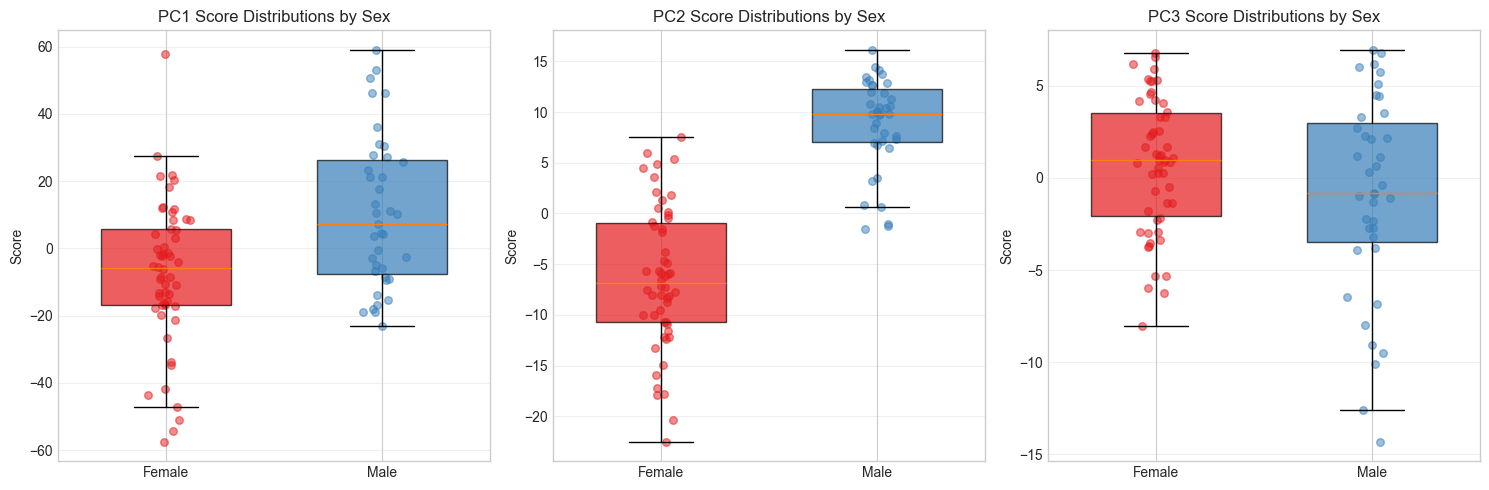

In [11]:

pc_scores_long = pc_scores_df.melt(
    id_vars=['child_id', 'sex'],
    value_vars=['PC1', 'PC2', 'PC3'],
    var_name='PC',
    value_name='Score'
)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, pc in enumerate(['PC1', 'PC2', 'PC3']):
    ax = axes[i]
    data_pc = pc_scores_long[pc_scores_long['PC'] == pc]
    
    positions = [0, 1]
    for j, (sex, color) in enumerate([('Female', '#E41A1C'), ('Male', '#377EB8')]):
        data_sex = data_pc[data_pc['sex'] == sex]['Score']
        bp = ax.boxplot([data_sex], positions=[positions[j]], widths=0.6,
                       patch_artist=True, showfliers=False)
        bp['boxes'][0].set_facecolor(color)
        bp['boxes'][0].set_alpha(0.7)
        y = data_sex
        x = np.random.normal(positions[j], 0.04, size=len(y))
        ax.scatter(x, y, alpha=0.5, s=30, color=color)
    
    ax.set_xlim(-0.5, 1.5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Female', 'Male'])
    ax.set_ylabel('Score')
    ax.set_title(f'{pc} Score Distributions by Sex')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Identifying Extreme Growth Patterns

We can use PC scores to identify children with unusual growth patterns.


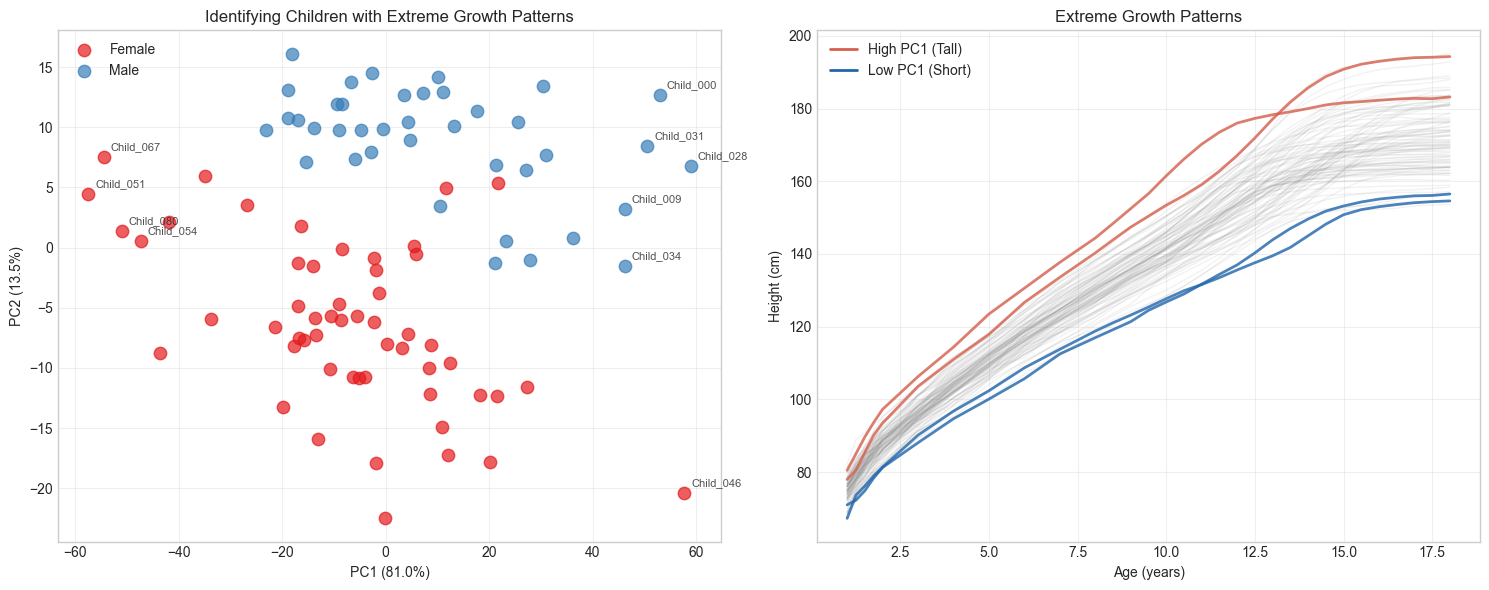

In [12]:
pc_scores_df['distance'] = np.sqrt(pc_scores_df['PC1']**2 + pc_scores_df['PC2']**2)

extreme_pc1_high = pc_scores_df.nlargest(3, 'PC1')
extreme_pc1_low = pc_scores_df.nsmallest(3, 'PC1')
top_extremes = pc_scores_df.nlargest(10, 'distance')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

for sex, color in [('Female', '#E41A1C'), ('Male', '#377EB8')]:
    mask = pc_scores_df['sex'] == sex
    ax1.scatter(pc_scores_df.loc[mask, 'PC1'], 
                pc_scores_df.loc[mask, 'PC2'],
                color=color, alpha=0.7, s=80, label=sex)

for idx, row in top_extremes.iterrows():
    ax1.annotate(row['child_id'], 
                (row['PC1'], row['PC2']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, alpha=0.8)

ax1.set_xlabel(f'PC1 ({var_explained[0]:.1f}%)')
ax1.set_ylabel(f'PC2 ({var_explained[1]:.1f}%)')
ax1.set_title('Identifying Children with Extreme Growth Patterns')
ax1.legend()
ax1.grid(True, alpha=0.3)

extreme_ids = list(extreme_pc1_high.iloc[:2]['child_id']) + list(extreme_pc1_low.iloc[:2]['child_id'])

for child_id in growth_df['child_id'].unique():
    child_data = growth_df[growth_df['child_id'] == child_id]
    ax2.plot(child_data['age'], child_data['height'], 
             alpha=0.1, color='gray', linewidth=1)

for child_id in extreme_ids:
    child_data = growth_df[growth_df['child_id'] == child_id]
    
    if child_id in extreme_pc1_high['child_id'].values:
        color = '#D6604D'
        label = 'High PC1 (Tall)'
    else:
        color = '#2166AC'
        label = 'Low PC1 (Short)'
    
    ax2.plot(child_data['age'], child_data['height'], 
             color=color, linewidth=2, alpha=0.8)

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='#D6604D', linewidth=2, label='High PC1 (Tall)'),
                   Line2D([0], [0], color='#2166AC', linewidth=2, label='Low PC1 (Short)')]
ax2.legend(handles=legend_elements)
ax2.set_xlabel('Age (years)')
ax2.set_ylabel('Height (cm)')
ax2.set_title('Extreme Growth Patterns')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Mathematical Background

For those interested in the theory, FPCA solves the eigenequation:

$\int C(s,t)\phi(t)dt = \lambda\phi(s)$

where $C(s,t)$ is the covariance function. Each curve is then represented as:

$x_i(t) = \mu(t) + \sum_{k=1}^{K} \xi_{ik} \phi_k(t)$

where:
- $\mu(t)$ = mean function
- $\phi_k(t)$ = k-th eigenfunction
- $\xi_{ik}$ = k-th PC score for individual i
- $K$ = number of components retained